### 7. Experiment Data Augmentation

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from tensorflow.keras import layers as L
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.resnet50 import (
        ResNet50, preprocess_input)

2025-04-20 20:16:44.053012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745180204.098185 1953184 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745180204.112066 1953184 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745180204.141267 1953184 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745180204.141297 1953184 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745180204.141300 1953184 computation_placer.cc:177] computation placer alr

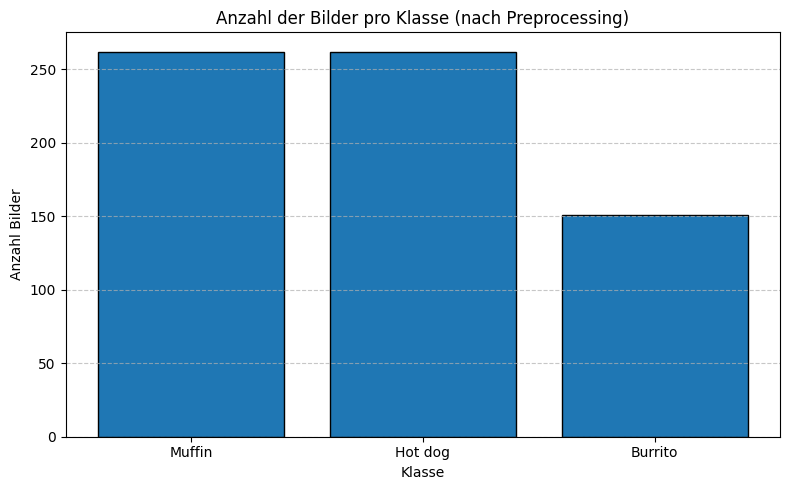

In [2]:
data_dir = "data_split_2/train"

# Bildanzahl pro Klasse
class_counts = {
    class_name: len([
        f for f in os.listdir(os.path.join(data_dir, class_name))
        if os.path.isfile(os.path.join(data_dir, class_name, f))
    ])
    for class_name in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, class_name))
}

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), edgecolor='black')
plt.title("Anzahl der Bilder pro Klasse (nach Preprocessing)")
plt.xlabel("Klasse")
plt.ylabel("Anzahl Bilder")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Klassenverteilung nach dem Preprocessing

Die Visualisierung zeigt, dass ein deutliches Ungleichgewicht zwischen den Klassen besteht:

- Muffin ist überrepräsentiert
- Hot dog und Burrito sind unterrepräsentiert

Dieses Ungleichgewicht kann das Training verzerren und sollte durch Data Augmentation berücksichtigt werden.

In [3]:
def plot_augmentation(aug_layer, img_path, title):
    img = Image.open(img_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_batch = tf.expand_dims(img_array, 0)

    augmented = aug_layer(img_batch)
    aug_img = tf.clip_by_value(augmented[0], 0.0, 1.0).numpy()

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(aug_img)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
example_image=f"{data_dir}/Burrito/000003.jpg"

I0000 00:00:1745180208.258125 1953184 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13397 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:3b:00.0, compute capability: 8.6


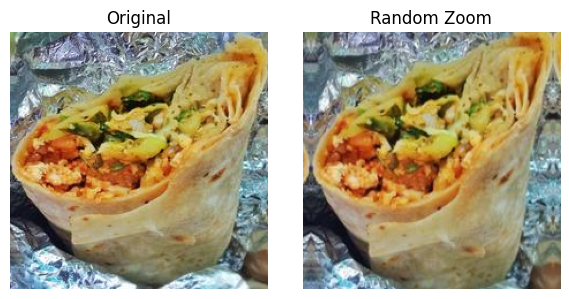

In [5]:
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.5, width_factor=0.2)
plot_augmentation(zoom_layer, example_image, "Random Zoom")

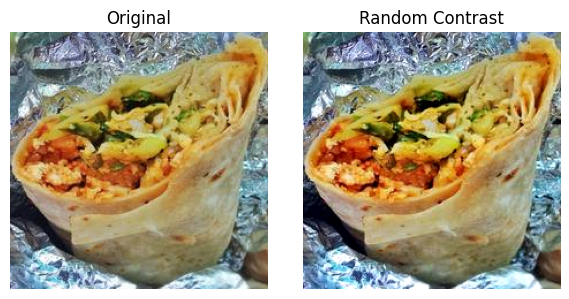

In [6]:
contrast_layer = tf.keras.layers.RandomContrast(factor=0.5)
plot_augmentation(contrast_layer, example_image, "Random Contrast")

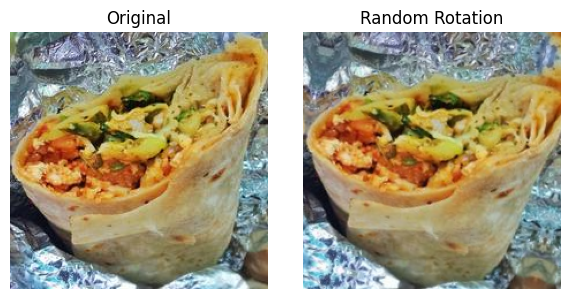

In [7]:
rotation_layer = tf.keras.layers.RandomRotation(factor=0.25)
plot_augmentation(rotation_layer, example_image, "Random Rotation")

### Load Training & Test Data

In [8]:
train_ds = image_dataset_from_directory(
    f"{data_dir}",
    image_size=(224, 224),
    batch_size=16,
    label_mode="categorical",
    shuffle=True
)

val_ds = image_dataset_from_directory(
    f"data_split_2/test",
    image_size=(224, 224),
    batch_size=16,
    label_mode="categorical"
)

Found 675 files belonging to 3 classes.
Found 227 files belonging to 3 classes.


In [9]:
# Extrahiere Labels aus dem train_ds
labels = []
for _, y in train_ds.unbatch():
    labels.append(np.argmax(y.numpy()))

# Berechne class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Konvertiere zu Dictionary (Keras erwartet das so)
class_weights = dict(enumerate(weights))

print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.490066225165563), 1: np.float64(0.8587786259541985), 2: np.float64(0.8587786259541985)}


2025-04-20 20:16:53.665160: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
def plot_histories(histories, save_path="training_results"):
    os.makedirs(save_path, exist_ok=True)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f"{name} (val)")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history.history['val_loss'], label=f"{name} (val)")
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"training_plot_{timestamp}.png"
    filepath = os.path.join(save_path, filename)
    plt.savefig(filepath, dpi=300)
    print(f"Plot gespeichert unter: {filepath}")

    plt.show()

def evaluate_and_plot_metrics(model, val_ds, class_names, name="model", save_dir="results/confusion_matrices"):
    y_pred_classes = []
    y_true = []

    for images, labels in val_ds:
        preds = model(images, training=False)
        y_pred_classes.extend(np.argmax(preds.numpy(), axis=1))

        if len(labels.shape) > 1 and labels.shape[-1] > 1:  # One-hot
            y_true.extend(np.argmax(labels.numpy(), axis=1))
        else:
            y_true.extend(labels.numpy())

    y_pred_classes = np.array(y_pred_classes)
    y_true = np.array(y_true)

    # Metriken berechnen
    acc = accuracy_score(y_true, y_pred_classes)
    prec = precision_score(y_true, y_pred_classes, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred_classes, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred_classes, average="weighted", zero_division=0)

    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.grid(False)

    # Save plot
    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, f"{name}_confusion_matrix.png")
    plt.savefig(plot_path, dpi=300)
    print(f"Confusion Matrix saved to: {plot_path}")
    plt.show()

### Define Pipelines

In [11]:
rescale = tf.keras.layers.Rescaling(1./255)

zoom_aug = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.3),
    rescale
])

contrast_aug = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.5),
    rescale
])

rotation_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),  # ~18°
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
])

In [12]:
def build_and_train_resnet50(
        name: str,
        train_ds,
        val_ds,
        *,
        augmentation_layer=None,
        num_classes: int = 3,
        class_weights=None,
        image_size: tuple = (224, 224),
        initial_lr: float = 3e-4,
        weight_decay: float = 1e-4,
        fine_tune_at: int = -40,
        dropout_rate: float = 0.3,
        label_smoothing: float = 0.05,
        mixed_precision_fp16: bool = False,
        epochs_phase1: int = 5,
        epochs_phase2: int = 5,
        patience: int = 10
    ):

    if mixed_precision_fp16:
        mixed_precision.set_global_policy("mixed_float16")

    base_model = ResNet50(
        include_top=False,
        input_shape=(*image_size, 3),
        weights="imagenet",
        pooling="avg"
    )
    base_model.trainable = False

    # Modell‑Head
    inputs = L.Input(shape=(*image_size, 3))
    if augmentation_layer is not None:
        x = augmentation_layer(inputs)
    else:
        x = inputs
    x = L.Lambda(preprocess_input, name="preprocess")(x)
    x = base_model(x, training=False)
    x = L.Dense(128, activation="relu")(x)
    x = L.Dropout(dropout_rate)(x)
    outputs = L.Dense(num_classes, activation="softmax",
                      dtype="float32")(x)

    model = tf.keras.Model(inputs, outputs, name=name)

    # Phase 1 – nur Head trainieren
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=initial_lr, weight_decay=weight_decay),
        loss=tf.keras.losses.CategoricalCrossentropy(
            label_smoothing=label_smoothing),
        metrics=["accuracy"]
    )

    hist1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs_phase1,
        class_weight=class_weights,
    )

    # Phase 2 – Fine‑Tuning (mit CosineDecay‑Schedule)
    base_model.trainable = True
    for layer in base_model.layers[:-abs(fine_tune_at)]:
        layer.trainable = False
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    decay_steps = epochs_phase2 * steps_per_epoch

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=decay_steps)

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay=weight_decay),
        loss=tf.keras.losses.CategoricalCrossentropy(
            label_smoothing=label_smoothing),
        metrics=["accuracy",
                 tf.keras.metrics.Precision(name="precision"),
                 tf.keras.metrics.Recall(name="recall")]
    )

    hist2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs_phase2,
        class_weight=class_weights,
    )

    for k in hist1.history.keys():
        hist1.history[k].extend(hist2.history[k])

    return model, hist1

def build_and_train_resnet50_scratch(
        name: str,
        train_ds,
        val_ds,
        *,
        augmentation_layer=None,
        num_classes: int = 3,
        class_weights=None,
        image_size: tuple = (224, 224),
        initial_lr: float = 1e-3,
        weight_decay: float = 1e-4,
        dropout_rate: float = 0.3,
        label_smoothing: float = 0.05,
        mixed_precision_fp16: bool = False,
        epochs: int = 10,
        patience: int = 10
    ):

    if mixed_precision_fp16:
        mixed_precision.set_global_policy("mixed_float16")

    base_model = ResNet50(
        include_top=False,
        input_shape=(*image_size, 3),
        weights=None,
        pooling="avg"
    )
    base_model.trainable = True

    inputs = L.Input(shape=(*image_size, 3))
    x = augmentation_layer(inputs) if augmentation_layer else inputs
    x = L.Lambda(preprocess_input, name="preprocess")(x)
    x = base_model(x, training=True)
    x = L.Dense(128, activation="relu")(x)
    x = L.Dropout(dropout_rate)(x)
    outputs = L.Dense(num_classes, activation="softmax",
                      dtype="float32")(x)

    model = tf.keras.Model(inputs, outputs, name=name)

    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    decay_steps = epochs * steps_per_epoch

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=decay_steps)

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=lr_schedule, weight_decay=weight_decay),
        loss=tf.keras.losses.CategoricalCrossentropy(
            label_smoothing=label_smoothing),
        metrics=["accuracy",
                 tf.keras.metrics.Precision(name="precision"),
                 tf.keras.metrics.Recall(name="recall")]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weights,
    )

    return model, history

In [13]:
rescale = tf.keras.layers.Rescaling(1./255)  # ⟵ NICHT verwenden, wenn preprocess_input aktiv!

zoom_aug = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.3)
])

contrast_aug = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.5)
])

rotation_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),  # ~18°
    tf.keras.layers.RandomZoom(0.1)
])

histories = {}

model_scratch, histories["scratch"] = build_and_train_resnet50_scratch(
    "scratch", train_ds, val_ds,
    class_weights=class_weights,
    augmentation_layer=None,
    epochs=10)

model_default, histories["default"] = build_and_train_resnet50(
    "default", train_ds, val_ds,
    class_weights=class_weights,
    augmentation_layer=None)

model_zoom, histories["zoom"] = build_and_train_resnet50(
    "zoom", train_ds, val_ds,
    class_weights=class_weights,
    augmentation_layer=zoom_aug)

model_cont, histories["contrast"] = build_and_train_resnet50(
    "contrast", train_ds, val_ds,
    class_weights=class_weights,
    augmentation_layer=contrast_aug)

model_rot, histories["rotation"] = build_and_train_resnet50(
    "rotation", train_ds, val_ds,
    class_weights=class_weights,
    augmentation_layer=rotation_aug)

Epoch 1/10


I0000 00:00:1745180263.004473 1953497 service.cc:152] XLA service 0x711f30002d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745180263.004536 1953497 service.cc:160]   StreamExecutor device (0): NVIDIA A2, Compute Capability 8.6
2025-04-20 20:17:46.013519: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745180275.433359 1953497 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-20 20:18:02.432278: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21647', 116 bytes spill stores, 116 bytes spill loads

2025-04-20 20:18:03.325337: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21647', 3940 byt

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.3505 - loss: 3.1794 - precision: 0.3559 - recall: 0.2862

2025-04-20 20:19:08.858452: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21647', 12 bytes spill stores, 12 bytes spill loads

2025-04-20 20:19:09.594971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21647', 8 bytes spill stores, 8 bytes spill loads

2025-04-20 20:19:09.595502: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21647', 8 bytes spill stores, 8 bytes spill loads

2025-04-20 20:19:09.792467: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21647', 112 bytes spill stores, 112 bytes spill loads

2025-04-20 20:19:10.306650: I external

43/43 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.3533 - loss: 3.1313 - precision: 0.3587 - recall: 0.2859 - val_accuracy: 0.3877 - val_loss: 1.1718 - val_precision: 0.5217 - val_recall: 0.1057
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.4607 - loss: 1.1849 - precision: 0.4711 - recall: 0.2012 - val_accuracy: 0.4097 - val_loss: 1.0899 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.4831 - loss: 1.0179 - precision: 0.6247 - recall: 0.1908 - val_accuracy: 0.4493 - val_loss: 1.0993 - val_precision: 0.5588 - val_recall: 0.0837
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.5504 - loss: 1.0190 - precision: 0.7813 - recall: 0.2138 - val_accuracy: 0.5374 - val_loss: 1.0238 - val_precision: 0.6353 - val_recall: 0.2379
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.5457 - loss: 1.0345 - precision: 0.7420 - recall: 0.2251 - val_accuracy: 0.5022 - val_loss: 1.

* Cosine‑Decay + AdamW reduziert die Lernrate sanft und bremst Gewichte ab – das stabilisiert sowohl Scratch‑ als auch TL‑Training.  
* Label‑Smoothing (0.05) entschärft Über­anpassung bei nur drei Klassen.  
* BatchNorm einfrieren verhindert, dass wenige neue Bilder die bereits gut kalibrierten BN‑Statistiken des vor­trainierten Modells zerstören.  
* Dropout 0.3 liefert leichte Regularisierung ohne den Feature‑Transfer zu behindern.

#### Scratch‑Funktion
* Keine Vor­trainierten Gewichte weights=None → alle Filter zufällig.  
* Ganzes Netz trainierbar von Anfang an; daher höhere Start‑LR (1e‑3) und mehr Epochen.  
* Kein zweistufiges Training nötig, da nichts eingefroren ist.  
* Dient als Referenz, um den Nutzen von Transfer‑Learning zu zeigen.

#### Transfer‑Learning‑Funktion
* Phase 1 – Backbone eingefroren trainable=False, nur der Kopf lernt 5 Epochen mit LR 3e‑4.  
* Phase 2 – letzte 40 Layer auftauen fine_tune_at=-40, BatchNorm Layer bleiben eingefroren, kleinere LR durch Cosine‑Schedule; weitere 5 Epochen Fine‑Tuning.

Plot gespeichert unter: training_results/training_plot_20250420_202958.png


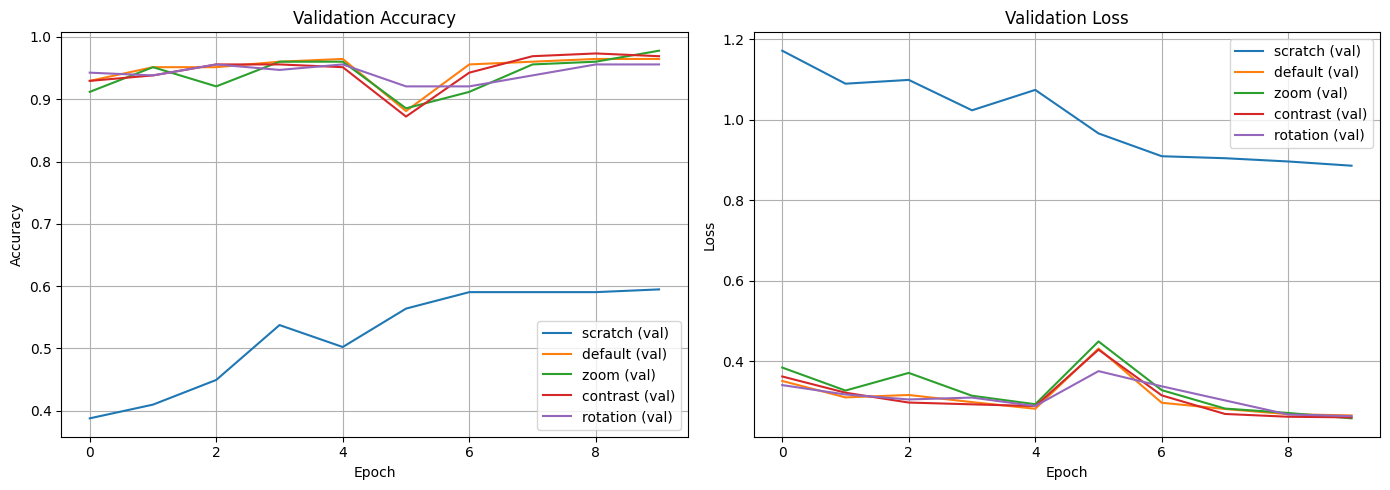

In [14]:
plot_histories(histories)

2025-04-20 20:30:03.271592: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Scratch - Accuracy: 0.5947, Precision: 0.5899, Recall: 0.5947, F1: 0.5902
Confusion Matrix saved to: results/confusion_matrices/Scratch_confusion_matrix.png


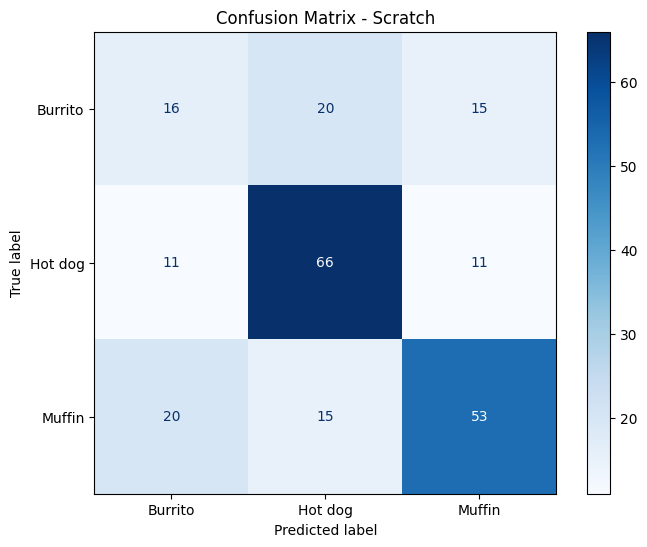

Default - Accuracy: 0.9648, Precision: 0.9647, Recall: 0.9648, F1: 0.9647
Confusion Matrix saved to: results/confusion_matrices/Default_confusion_matrix.png


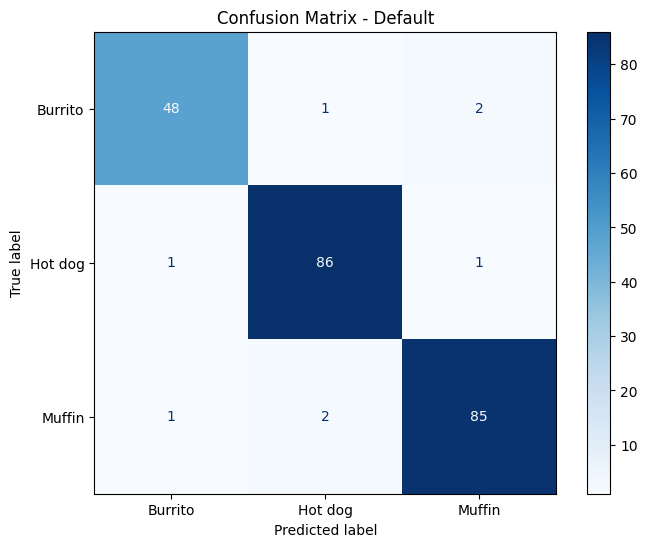

2025-04-20 20:30:13.205490: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Zoom - Accuracy: 0.9780, Precision: 0.9782, Recall: 0.9780, F1: 0.9780
Confusion Matrix saved to: results/confusion_matrices/Zoom_confusion_matrix.png


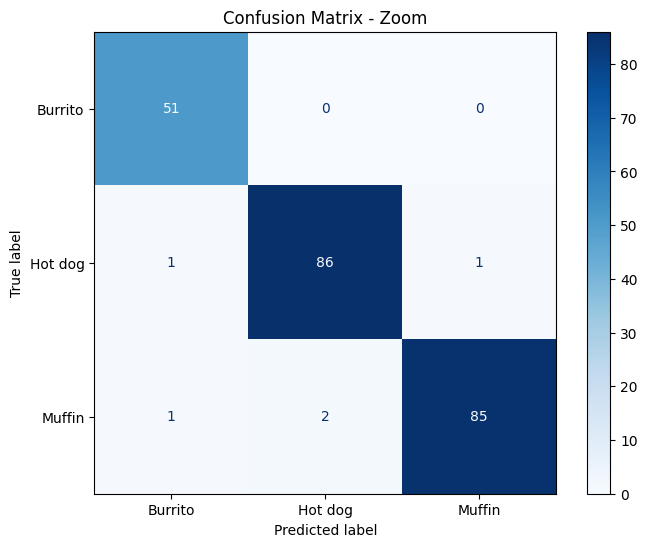

Contrast - Accuracy: 0.9692, Precision: 0.9693, Recall: 0.9692, F1: 0.9692
Confusion Matrix saved to: results/confusion_matrices/Contrast_confusion_matrix.png


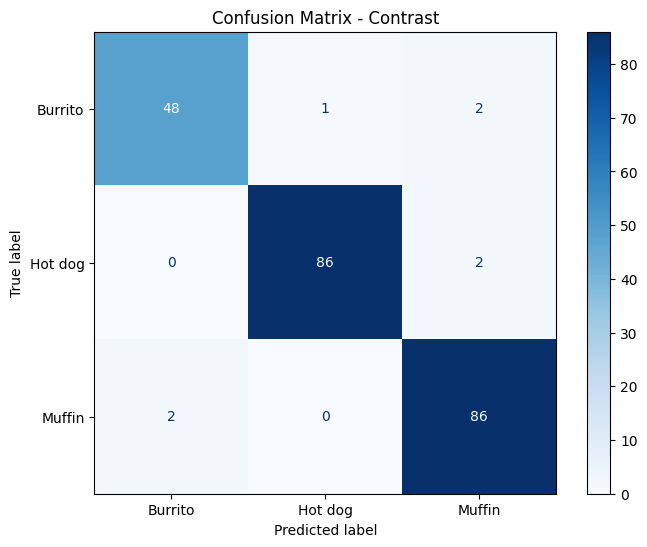

Rotation - Accuracy: 0.9559, Precision: 0.9564, Recall: 0.9559, F1: 0.9559
Confusion Matrix saved to: results/confusion_matrices/Rotation_confusion_matrix.png


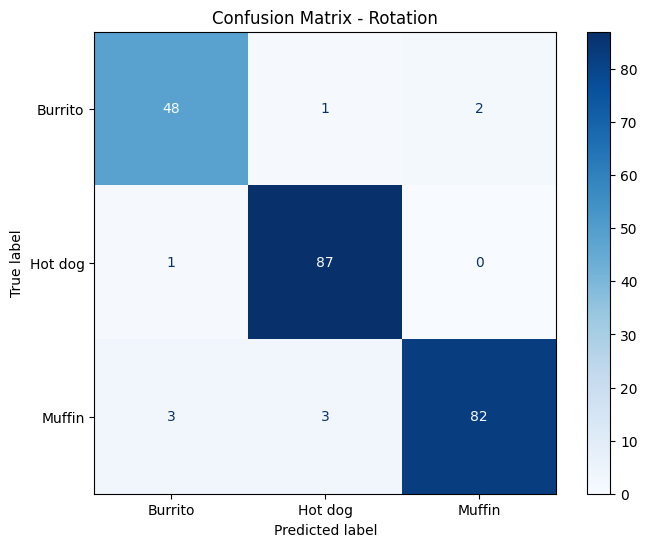

In [15]:
class_names = train_ds.class_names
evaluate_and_plot_metrics(model=model_scratch, val_ds=val_ds, class_names=class_names, name="Scratch")
evaluate_and_plot_metrics(model=model_default, val_ds=val_ds, class_names=class_names, name="Default")
evaluate_and_plot_metrics(model=model_zoom, val_ds=val_ds, class_names=class_names, name="Zoom")
evaluate_and_plot_metrics(model=model_cont, val_ds=val_ds, class_names=class_names, name="Contrast")
evaluate_and_plot_metrics(model=model_rot, val_ds=val_ds, class_names=class_names, name="Rotation")